In [1]:
#import yfinance as yf
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from arch import arch_model
#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.tsa.stattools import adfuller

# Fetch CAG data
#cag_data = yf.download('CAG', start='2015-01-01', end='2024-12-31')






In [2]:
#cag = cag_data.copy()
#cag = cag.reset_index(drop=False)
#cag.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
#cag= cag.set_index('Date')

#cag = cag['Close']

#cag.to_csv('CAG_2015_2024.csv')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

cag = pd.read_csv('CAG_2015_2024.csv', parse_dates=True, index_col=0)

cag.head()

,Close
Date,
2015-01-02,20.157829
2015-01-05,19.938356
2015-01-06,19.741388
2015-01-07,20.208479
2015-01-08,20.647425


In [13]:
# Calculate log-returns
cag_log_returns = np.log(cag / cag.shift(1)).dropna()

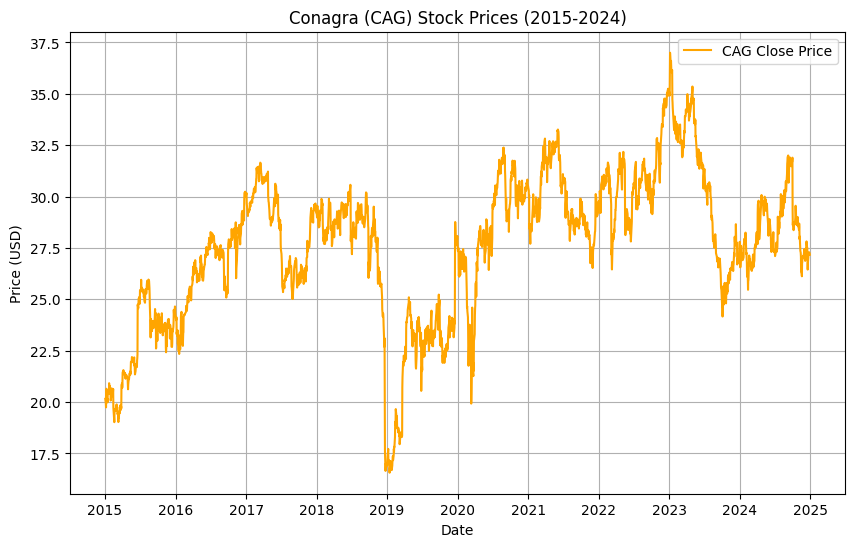

In [14]:


plt.figure(figsize=(10, 6))
plt.plot(cag['Close'], label='CAG Close Price', color='orange')
plt.title('Conagra (CAG) Stock Prices (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

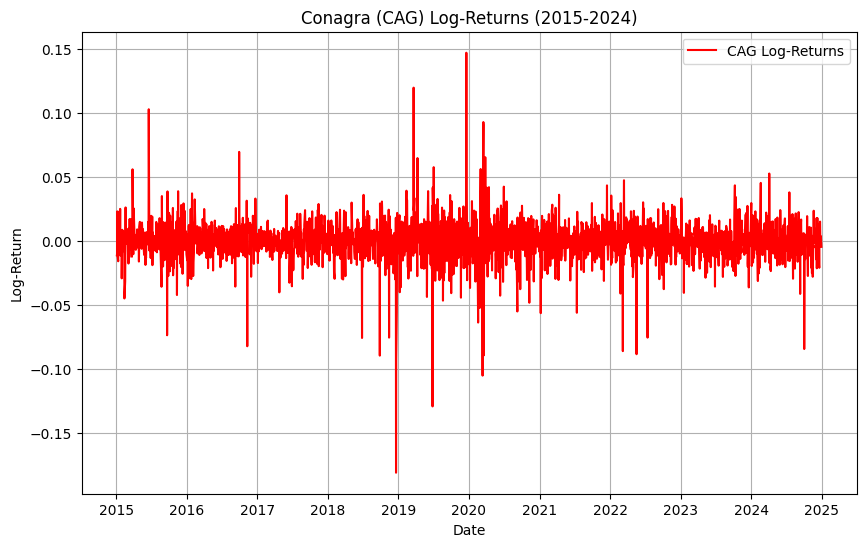

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(cag_log_returns, label='CAG Log-Returns', color='red')
plt.title('Conagra (CAG) Log-Returns (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Log-Return')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print("CAG Log-Returns Summary Statistics:")
print(cag_log_returns.describe())
print(f"Skewness: {cag_log_returns.skew()}")
print(f"Kurtosis: {cag_log_returns.kurtosis()}")

CAG Log-Returns Summary Statistics:
             Close
count  2514.000000
mean      0.000119
std       0.016161
min      -0.180741
25%      -0.007273
50%       0.000420
75%       0.007984
max       0.147291
Skewness: Close   -0.712066
dtype: float64
Kurtosis: Close    16.702223
dtype: float64


In [19]:
adf_result = adfuller(cag_log_returns)
print("\nADF Test Results for CAG Log-Returns:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Test Results for CAG Log-Returns:
ADF Statistic: -30.4158
p-value: 0.0000


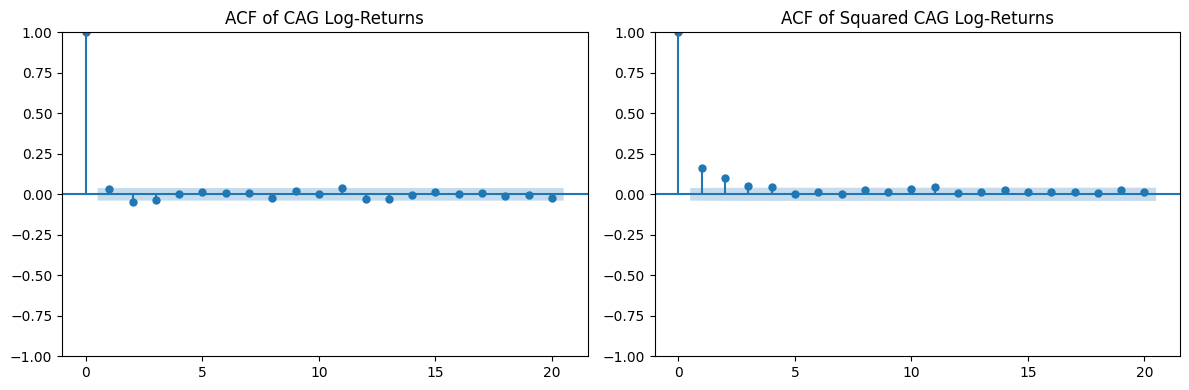

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(cag_log_returns, lags=20, ax=plt.gca())
plt.title('ACF of CAG Log-Returns')
plt.subplot(1, 2, 2)
plot_acf(cag_log_returns**2, lags=20, ax=plt.gca())
plt.title('ACF of Squared CAG Log-Returns')
plt.tight_layout()
plt.show()

In [25]:
cag_log_returns

,Close
Date,
2015-01-05,-0.010947
2015-01-06,-0.009928
2015-01-07,0.023385
2015-01-08,0.021488
2015-01-09,-0.012341
...,...
2024-12-23,0.015374
2024-12-24,0.003988
2024-12-26,-0.003261


In [26]:
# Fit GARCH(1,1) model
cag_garch = arch_model(cag_log_returns['Close'], vol='Garch', p=1, q=1, mean='zero', rescale=True)
cag_garch_fit = cag_garch.fit(disp='off')
print(cag_garch_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4651.93
Distribution:                  Normal   AIC:                           9309.86
Method:            Maximum Likelihood   BIC:                           9327.35
                                        No. Observations:                 2514
Date:                Sat, Mar 15 2025   Df Residuals:                     2514
Time:                        15:35:22   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0127  8.311e-03      1.531      0.126 

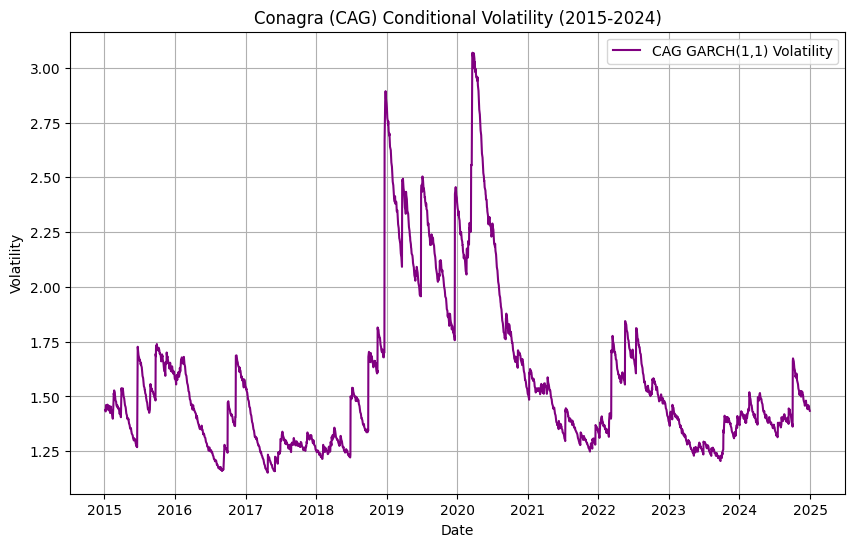

In [27]:
# Extract and plot conditional volatility
cag_volatility = cag_garch_fit.conditional_volatility
plt.figure(figsize=(10, 6))
plt.plot(cag_volatility, label='CAG GARCH(1,1) Volatility', color='purple')
plt.title('Conagra (CAG) Conditional Volatility (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
from scipy.stats import norm
cag_vol_forecast = (cag_garch_fit.forecast(horizon=1).variance.iloc[-1] ** 0.5)
cag_VaR_95 = norm.ppf(0.01) * cag_vol_forecast
cag_ES_95 = - (norm.pdf(norm.ppf(0.05)) / 0.05) * cag_vol_forecast
print(f"CAG VaR (99%): {cag_VaR_95}")
print(f"CAG ES (95%): {cag_ES_95}")

CAG VaR (99%): h.1   -3.31967
Name: 2024-12-30 00:00:00, dtype: float64
CAG ES (95%): h.1   -2.943466
Name: 2024-12-30 00:00:00, dtype: float64
